In [1]:
import ee
import geemap
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
from IPython.display import Javascript, display
import pickle 
import datetime 

try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

In [ ]:
#run this to download the model
!wget -O "sentinelModelV2.sav" "https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/Task11/trained_model_smote_sentinelV2.sav"

In [2]:

style = {'description_width': 'initial'}

end_year = widgets.IntSlider(description='Year:', value=2020, min=2016, max=2021, style=style)
end_month = widgets.IntSlider(description='Month:', value=5, min=1, max=12, style=style)
end_day = widgets.IntSlider(description='Day:', value=5, min=1, max=31, style=style)
hbox = widgets.VBox([end_year, end_month, end_day ])
#display(hbox)
widgets.VBox([widgets.Label('Choose the date'),hbox])

In [3]:
Map = geemap.Map(center=[14.607989,-14.531731], zoom=7)
Map.add_basemap('Google Satellite Hybrid')
Map

Map(center=[14.607989, -14.531731], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [11]:
#1 Acre = 4047 m²
#1 Acre  = 0.404686 hectare
meterToAcre = (1/4047)
acreToHectare = 0.404686
startDate=None
datePicker_Start=None
datePicker_End=None
roi =None
area = None

#def selectDate():
#Select date range of 30 days
startDate = datetime.datetime(end_year.value, end_month.value, end_day.value) - datetime.timedelta(days=30)
datePicker_Start =  str(startDate.year)+"-"+str(startDate.month)+"-"+str(startDate.day)
datePicker_End =  str(end_year.value)+"-"+str(end_month.value)+"-"+str(end_day.value)


# To check total area  of selected polygon
def roiInfo(): 
    feature = Map.draw_last_feature
    roi = feature.geometry()
    coordinate = roi.getInfo()['coordinates']
    polygon = ee.Geometry.Polygon(coordinate)
    area = polygon.area().getInfo()
    acre = area * meterToAcre
    print('area: ', area,"m²")
    print('Acre: ', acre)
    print('Hectare: ', acre * acreToHectare)
    return area

def plotResult(prediction):
    # Create colormap suitable for colourblind people and with grey as 0 for "No classification"
    cmap = sns.color_palette("colorblind", as_cmap=True)
    cmap[0], cmap[7] = cmap[7], cmap[0]

    # Plot heatmap
    ax = sns.heatmap(prediction, vmin=0, vmax=9, cmap=cmap)

    # Set colourbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.5 + (8/9*x) for x in range(10)])
    cbar.set_ticklabels(["No classification", "Cotton", "Dates", "Grass", "Lucern", "Maize", "Pecan", "Vacant", "Vineyard", "Vineyard & Pecan"])

    # Remove axis ticks
    plt.setp(ax, yticks=[], xticks=[]);

def predictYeild(samplePrediction, crops, areaOfOnePixel):
    
        
    def calculateArea(cropCount):
        return cropCount*meterToAcre*areaOfOnePixel

    predictionCount = np.unique(samplePrediction, return_counts=True)
    crop,totalcount = predictionCount[0],predictionCount[1]

    for cropId,cropCount in zip(crop,totalcount):
        print("{} : {} acre".format(crops[cropId],calculateArea(cropCount)))
        

#define global variables
feature = Map.draw_last_feature
roi = feature.geometry()


#filename_Sentinel = 'models/sentinelModelV2.sav'
filename_Sentinel = 'sentinelModelV2.sav'

crops = {
    0:"No crop",
    1:"Cotton",
    2:"Dates",
    3:"Grass",
    4:"Lucern",
    5:"Maize",
    6:"Pecan",
    7:"Vacant",
    8:"Vineyard",
    9:"Vineyard & Pecan"
}

print("Area statistics:")
area = roiInfo()



Area statistics:
area:  55230.62179835674 m²
Acre:  13.647299678368357
Hectare:  5.522871117640177


In [5]:
class Sentinel:
    def __init__(self):
        self.model = None
        self.prediction = None
       

    def getImage(datePicker_Start, datePicker_End, roi, cloud=5):

        def maskS2clouds(image):
            qa = image.select('QA60')
            cloudBitMask = 1 << 10
            cirrusBitMask = 1 << 11
            mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
                     qa.bitwiseAnd(cirrusBitMask).eq(0))
            return image.updateMask(mask).divide(10000) 

        # Load Sentinel-2 TOA reflectance data.
        imageCollection = ee.ImageCollection('COPERNICUS/S2') \
            .filterDate(datePicker_Start, datePicker_End) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud)) \
            .map(maskS2clouds) \
            .filterBounds(roi) \
            .sort('CLOUDY_PIXEL_PERCENTAGE')


        count = imageCollection.size().getInfo()
        if count<=0:
            print("No images found for the date range.\nChoose different date")
            return None
        print("Total satellite images available across the date range:",count)

        rawImg = ee.Image(imageCollection.toList(imageCollection.size()).get(0))

        return rawImg

    
    
    
    def createMatrix(rawImg,roi):
        
        bands = ['B1','B10','B11','B12','B2','B3','B4','B5','B6','B7','B8','B8A','B9','NDVI']
        matrix = {'B1':None,
                  'B10':None,
                  'B11':None,
                  'B12':None,
                  'B2':None,
                  'B3':None,
                  'B4':None,
                  'B5':None,
                  'B6':None,
                  'B7':None,
                  'B8':None,
                  'B8A':None,
                  'B9':None,
                  'NDVI':None
                 }
        Res_ten= rawImg.select(['B2'])
        Res_ten = geemap.ee_to_numpy(Res_ten, region=roi)
        targetSize = (Res_ten.shape[1],Res_ten.shape[0])
        
        for band in bands:
            print("Processing:",band)
            
            if band == "NDVI":
                NIR = matrix['B8']
                RED = matrix['B4']
                NDVI_val = (NIR-RED)/(NIR+RED)
                matrix[band] = NDVI_val
            else:
                temp = rawImg.select([band])
                temp = geemap.ee_to_numpy(temp, region=roi)
                matrix[band] = cv2.resize(temp,targetSize,interpolation=cv2.INTER_NEAREST)      
                

        FinalImage = np.dstack((matrix['B1'],matrix['B10'],matrix['B11'],
                               matrix['B12'],matrix['B2'],matrix['B3'],
                               matrix['B4'],matrix['B5'],matrix['B6'],
                               matrix['B7'],matrix['B8'],matrix['B8A'],
                               matrix['B9'],matrix['NDVI']))
        

        return FinalImage
    
    def calculate_one_pixel_area(matrix):        
        TotalPixel = matrix.shape[0]*matrix.shape[1]
        print("Total Pixel:",TotalPixel)
        areaOfOnePixel = area/TotalPixel
        print("Area of one pixel:",areaOfOnePixel,"acre")
        print('Total area: ', area,"m²")
        return areaOfOnePixel
    
    def loadModel(self,filename_Sentinel):
        self.model = pickle.load(open(filename_Sentinel, 'rb'))
        
    def predictCrop(self, inputBands):
        return self.model.predict_proba([inputBands])
    
    def initPrediction(self, row, col):
        self.prediction = np.zeros([row,col])
        

    def updateMatrix(self,inputBands,row,col,threshold =0.6):
        pred = self.predictCrop(inputBands)
        if pred.max() >= threshold:
            self.prediction[row][col] = pred.argmax()+1  # Add 1 to keep "no crop classified" as 0

     
        



In [6]:
#load the model
sentinel = Sentinel()
print("Loading model")
sentinel.loadModel(filename_Sentinel)
print("Finished loading model")

Loading model


/home/praveenkanna/anaconda3/envs/gee/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Finished loading model


/home/praveenkanna/anaconda3/envs/gee/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/praveenkanna/anaconda3/envs/gee/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Total satellite images available across the date range: 4
Processing: B1
Processing: B10
Processing: B11
Processing: B12
Processing: B2
Processing: B3
Processing: B4
Processing: B5
Processing: B6
Processing: B7
Processing: B8
Processing: B8A
Processing: B9
Processing: NDVI
Preprocessed image:  (18, 33, 14)
Total Pixel: 594
Area of one pixel: 92.98084477837835 acre
Total area:  55230.62179835674 m²
Inferencing the model.
Please Wait...
Finished prediction.



Plotting result
Calculating yeild
No crop : 10.798368432379004 acre
Maize : 0.022975251983785114 acre
Vacant : 2.825955994005569 acre


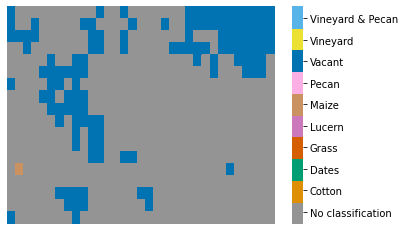

In [13]:

#get the lowest cloud image in last 30 days
rawImg = Sentinel.getImage(datePicker_Start,datePicker_End,roi)

if rawImg:
    print("Collecting data")
    Img = Sentinel.createMatrix(rawImg,roi)
    print("Preprocessed image: ",Img.shape)
    areaOfOnePixel = Sentinel.calculate_one_pixel_area(Img)

    #Initialize prediction matrix
    sentinel.initPrediction(Img.shape[0],Img.shape[1])
    print("Inferencing the model.\nPlease Wait...")


    #loop through each pixel
    for row in range(Img.shape[0]):
        for col in range(Img.shape[1]):
            #inference the model
            sentinel.updateMatrix(Img[row][col], row, col)
    print("Finished prediction.\n\n\n\nPlotting result")    
    plotResult(sentinel.prediction)
    
    print("Calculating yeild")
    predictYeild(sentinel.prediction, crops, areaOfOnePixel)
    
    

